In [1]:
import warnings
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import timm

warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def get_dataloaders(root = 'C:\\Users\\86135\\Downloads\\FER2013', bs=64, augment=True):
    mu, st = 0, 255

    test_transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.Grayscale(num_output_channels=1),
        transforms.TenCrop(40),
        transforms.Lambda(lambda crops: torch.stack([
            transforms.Normalize((mu,), (st,))(transforms.ToTensor()(crop)) for crop in crops
        ]))
    ])

    if augment:
        train_transform = transforms.Compose([
            transforms.Resize((48, 48)),
            transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.Grayscale(num_output_channels=1),
            transforms.TenCrop(40),
            transforms.Lambda(lambda crops: torch.stack([
                transforms.Normalize((mu,), (st,))(transforms.ToTensor()(crop)) for crop in crops
            ]))
        ])
    else:
        train_transform = test_transform

    train_dataset = datasets.ImageFolder(root=f'{root}/train', transform=train_transform)
    test_dataset = datasets.ImageFolder(root=f'{root}/test', transform=test_transform)

    trainloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

    return trainloader, testloader

In [3]:
class VggFeatures(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=3, padding=1)

        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1a = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)

        self.bn2a = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)

        self.bn3a = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

        self.bn4a = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)

        self.lin1 = nn.Linear(512 * 2 * 2, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)

        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
        # print(x.shape)

        x = x.view(-1, 512 * 2 * 2)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))

        return x


class Vgg(VggFeatures):
    def __init__(self, drop=0.2):
        super().__init__(drop)
        self.lin3 = nn.Linear(4096, 7)

    def forward(self, x):
        x = super().forward(x)
        x = self.lin3(x)
        return x

In [4]:
def train(model, dataloader, criterion, optimizer, scaler, Ncrop=True):
    model.train()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        with autocast():
            if Ncrop:
                bs, ncrops, c, h, w = inputs.shape
                inputs = inputs.view(-1, c, h, w)
                labels = torch.repeat_interleave(labels, repeats=ncrops, dim=0)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            loss_tr += loss.item()
            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / len(dataloader)
    return acc, loss


def evaluate(model, dataloader, criterion, Ncrop=True):
    model.eval()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    all_true_labels = []
    all_pred_labels = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            if Ncrop:
                bs, ncrops, c, h, w = inputs.shape
                inputs = inputs.view(-1, c, h, w)
                outputs = model(inputs)
                outputs = outputs.view(bs, ncrops, -1)
                outputs = torch.sum(outputs, dim=1) / ncrops
            else:
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_tr += loss.item()
            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n_samples += labels.size(0)
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(preds.cpu().numpy())
    acc = 100 * correct_count / n_samples
    loss = loss_tr / len(dataloader)
    precision = precision_score(all_true_labels, all_pred_labels, average='weighted')
    recall = recall_score(all_true_labels, all_pred_labels, average='weighted')
    f1 = f1_score(all_true_labels, all_pred_labels, average='weighted')
    conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)
    return acc, loss, precision, recall, f1, conf_matrix

Epoch   1 | Train Acc: 39.0616% | Train Loss: 1.542266
           | Test Acc:  51.7275% | Test Loss:  1.268459 | Precision: 0.5391 | Recall: 0.5173 | F1: 0.4874
Epoch  10 | Train Acc: 65.5920% | Train Loss: 0.914619
           | Test Acc:  62.5383% | Test Loss:  1.007234 | Precision: 0.6634 | Recall: 0.6254 | F1: 0.6002
Epoch  20 | Train Acc: 71.0927% | Train Loss: 0.774516
           | Test Acc:  66.9407% | Test Loss:  0.909326 | Precision: 0.6854 | Recall: 0.6694 | F1: 0.6630
Epoch  30 | Train Acc: 76.9177% | Train Loss: 0.624525
           | Test Acc:  68.0412% | Test Loss:  0.887564 | Precision: 0.6797 | Recall: 0.6804 | F1: 0.6793
Epoch  40 | Train Acc: 84.2938% | Train Loss: 0.432036
           | Test Acc:  69.1279% | Test Loss:  0.991189 | Precision: 0.7051 | Recall: 0.6913 | F1: 0.6922
Epoch  50 | Train Acc: 87.3458% | Train Loss: 0.349237
           | Test Acc:  69.8663% | Test Loss:  1.067143 | Precision: 0.7131 | Recall: 0.6987 | F1: 0.6929
Epoch  60 | Train Acc: 89.5197% | 

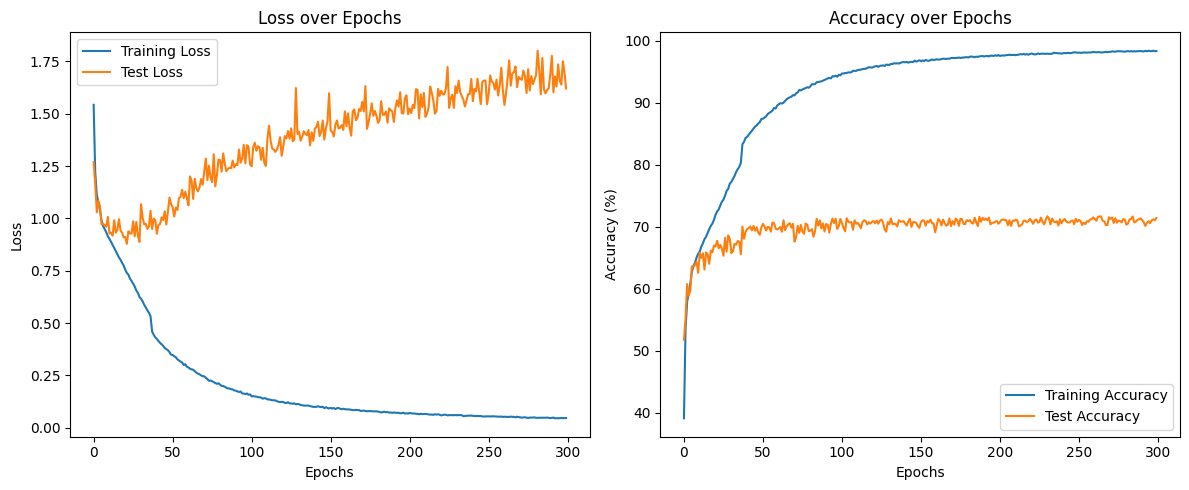

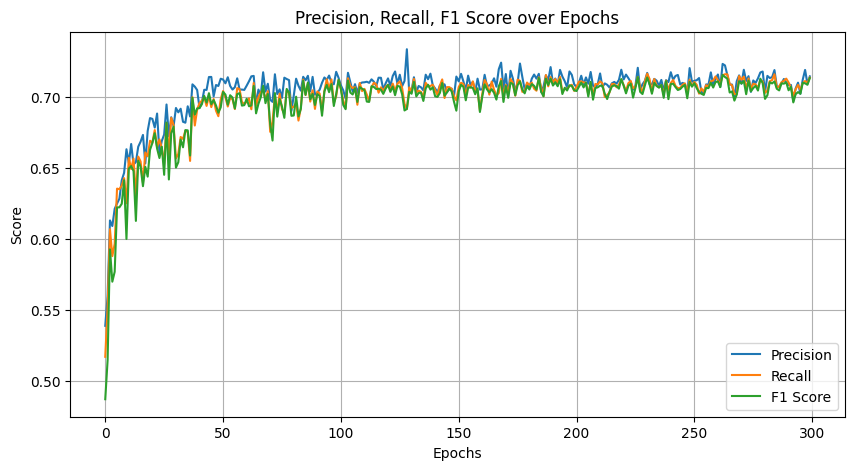

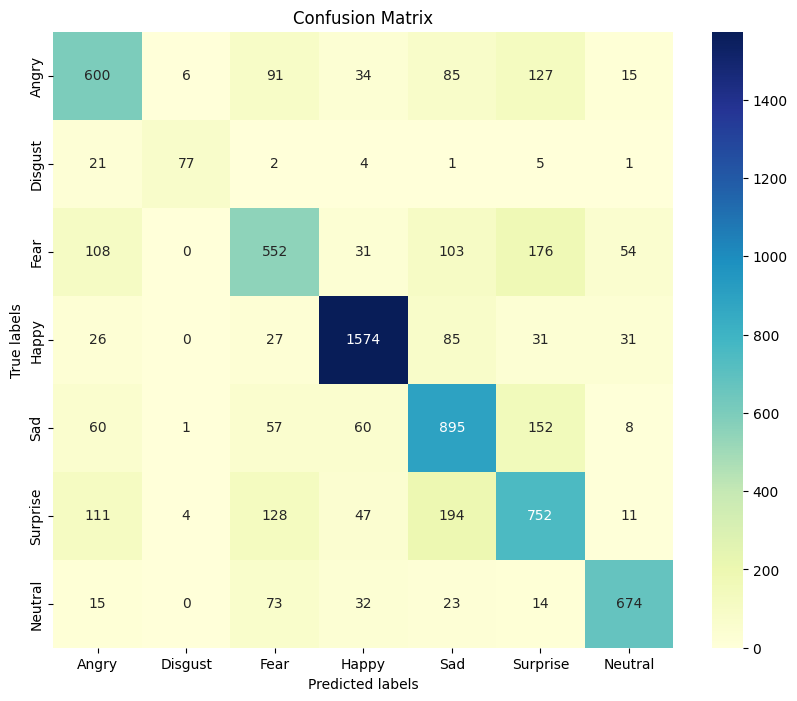


Final Test Metrics:
Accuracy: 71.3848%
Loss: 1.619983
Precision: 0.7147
Recall: 0.7138
F1 Score: 0.7135

Confusion Matrix:
[[ 600    6   91   34   85  127   15]
 [  21   77    2    4    1    5    1]
 [ 108    0  552   31  103  176   54]
 [  26    0   27 1574   85   31   31]
 [  60    1   57   60  895  152    8]
 [ 111    4  128   47  194  752   11]
 [  15    0   73   32   23   14  674]]


In [5]:
trainloader, testloader = get_dataloaders('C:\\Users\\86135\\Downloads\\FER2013', bs=64, augment=True)

model = Vgg()
model = model.to(device)

learning_rate = 0.01
scaler = GradScaler()

optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.5, last_epoch=-1, verbose=True)

criterion = nn.CrossEntropyLoss()

epochs = 300
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []
test_f1s = []
test_confusion_matrices = []

best_f1 = 0.0
best_model = None

for epoch in range(epochs):
    acc_tr, loss_tr = train(model, trainloader, criterion, optimizer, scaler)
    train_losses.append(loss_tr)
    train_accuracies.append(acc_tr)

    acc_v, loss_v, precision, recall, f1, conf_matrix = evaluate(model, testloader, criterion)
    test_losses.append(loss_v)
    test_accuracies.append(acc_v)
    test_precisions.append(precision)
    test_recalls.append(recall)
    test_f1s.append(f1)
    test_confusion_matrices.append(conf_matrix)

    if f1 > best_f1:
        best_f1 = f1
        best_model = copy.deepcopy(model.state_dict())

    scheduler.step(acc_tr)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch {epoch + 1:3d} | Train Acc: {acc_tr:.4f}% | Train Loss: {loss_tr:.6f}')
        print(f'           | Test Acc:  {acc_v:.4f}% | Test Loss:  {loss_v:.6f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}')

# Save best model
torch.save(best_model, 'best_vgg_fer2013.pth')

# Final evaluation
acc_test, loss_test, precision_test, recall_test, f1_test, conf_matrix_test = evaluate(model, testloader, criterion)

# Emotion class labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Precision/Recall/F1
plt.figure(figsize=(10, 5))
plt.plot(test_precisions, label='Precision')
plt.plot(test_recalls, label='Recall')
plt.plot(test_f1s, label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 Score over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print final metrics
print(f'\nFinal Test Metrics:')
print(f'Accuracy: {acc_test:.4f}%')
print(f'Loss: {loss_test:.6f}')
print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'F1 Score: {f1_test:.4f}')
print('\nConfusion Matrix:')
print(conf_matrix_test)